# Find eigenvalues of the K matrices for varying PDE parameter "a"

In [63]:
# import all modules
# Third-party
import numpy as np
import torch

# Local files
import utilities
import train_NN as train
import neural_network as net

# Choose a device to run on - either CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:
# True PDE - Network will satify this PDE at the end of training
def pde_fn(x, a):
    # PDE: u_xx = -(pi*a)^2.sin(pi*a*x)
    u_xx = -(np.pi * a)**2 * np.sin(np.pi * a * x)
    return u_xx

# True solution - Network will try to learn this
def u(x, a):
    return np.sin(np.pi * a * x)

In [65]:
def create_1D_training_data(a, no_of_data_samples=100):
    dom_coords = np.array([[0.0],
                        [1.0]])
    X_bc1 = dom_coords[0, 0] * np.ones((no_of_data_samples // 2, 1))
    X_bc2 = dom_coords[1, 0] * np.ones((no_of_data_samples // 2, 1))

    X_u = np.vstack([X_bc1, X_bc2]) # data for BC
    Y_u = u(X_u, a) # y data for BC

    X_r = np.linspace(dom_coords[0, 0],
                    dom_coords[1, 0], no_of_data_samples)[:, None] # data for residual
    Y_r = pde_fn(X_r, a) # y data for residual
    return (X_u, Y_u, X_r, Y_r)  

In [66]:
import os

a_values_to_test = [1, 2, 4]
seed = 1
data_directory = "./data_ntk/"
width = 100
depth = 2
max_itr = 1
save_data_freq = 5
save_eigenvalues_only = True

for avalue in a_values_to_test:
    # make a sub-directory for saving results of each "a" value
    save_data_location = data_directory+"a_{}".format(avalue)
    if not os.path.exists(save_data_location):        
        os.mkdir(save_data_location)
    # Create traning data for the given "a"
    train_data = create_1D_training_data(avalue)
    # Create model
    X_r = train_data[2]
    mean = X_r.mean(axis=0)  # (1, dim) values
    std = X_r.std(axis=0)  # (1, dim) values  
    # Create network
    model = net.PINN(no_of_neurons=width,
                     no_of_h_layers=depth,
                     seed=avalue*5,
                     mean= mean.item(), std =std.item())
    model.to(device)
    details = train.train_nn_model(model, train_data=train_data,
                                no_iterations=max_itr, device=device,
                                save_data_location=save_data_location,
                                save_data_frequency=save_data_freq,
                                save_eigs_only=save_eigenvalues_only)
    del model

## Calculate the eigenvalues

In [67]:
import utilities
eig_vals1 = np.load("./data_ntk/a_1/eigenvalues_itr_0.npz")
eig_vals2 = np.load("./data_ntk/a_2/eigenvalues_itr_0.npz")
eig_vals4 = np.load("./data_ntk/a_4/eigenvalues_itr_0.npz")
eig_vals.files

['eig_uu', 'eig_rr', 'eig_K']

In [68]:
eig_uu1 = eig_vals1['eig_uu']
eig_uu2 = eig_vals2['eig_uu']
eig_uu4 = eig_vals4['eig_uu']
eig_rr1 = eig_vals1['eig_rr']
eig_rr2 = eig_vals2['eig_rr']
eig_rr4 = eig_vals4['eig_rr']
eig_K1 = eig_vals1['eig_K']
eig_K2 = eig_vals2['eig_K']
eig_K4 = eig_vals4['eig_K']

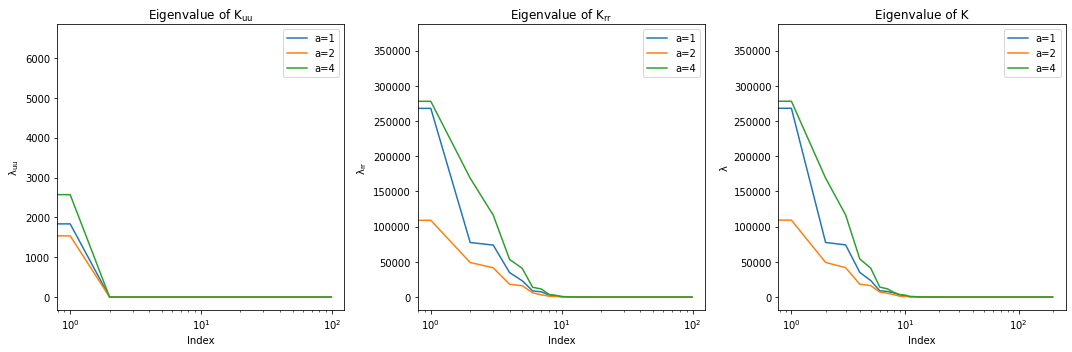

In [78]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize= (15,5))
ax[0].semilogx(eig_uu1, label ='a=1')
ax[0].semilogx(eig_uu2, label ='a=2')
ax[0].semilogx(eig_uu4, label ='a=4')
ax[0].title.set_text("Eigenvalue of $\mathregular{K_{uu}}$")
ax[0].legend()
ax[0].set_xlabel("Index")
ax[0].set_ylabel("$\mathregular{\lambda_{uu}}$")
ax[1].semilogx(eig_rr1, label = 'a=1')
ax[1].semilogx(eig_rr2, label = 'a=2')
ax[1].semilogx(eig_rr4, label = 'a=4')
ax[1].title.set_text("Eigenvalue of $\mathregular{K_{rr}}$")
ax[1].legend()
ax[1].set_xlabel("Index")
ax[1].set_ylabel("$\mathregular{\lambda_{rr}}$")
ax[2].semilogx(eig_K1, label = 'a=1')
ax[2].semilogx(eig_K2, label = 'a=2')
ax[2].semilogx(eig_K4, label = 'a=4')
ax[2].title.set_text("Eigenvalue of K")
ax[2].legend()
ax[2].set_xlabel("Index")
ax[2].set_ylabel("$\mathregular{\lambda}}$")
plt.tight_layout()

## Relative change of parameters

In [82]:
import os

seed = 1
data_directory = "./data_ntk/"
widths = [10, 100, 500]
depth = 1
max_itr = 10000
save_data_freq = 100
save_eigenvalues_only = True

# make a sub-directory for saving results of each "width" value
for w in widths:
    save_data_location = data_directory+"width_{}".format(w)
    if not os.path.exists(save_data_location):        
        os.mkdir(save_data_location)
    # Create traning data for the given "a"
    train_data = create_1D_training_data(avalue)
    # Create model
    X_r = train_data[2]
    mean = X_r.mean(axis=0)  # (1, dim) values
    std = X_r.std(axis=0)  # (1, dim) values  
    # Create network
    model = net.PINN(no_of_neurons=w,
                     no_of_h_layers=depth,
                     seed=1,
                     mean= mean.item(), std =std.item())
    model.to(device)
    details = train.train_nn_model(model, train_data=train_data,
                                no_iterations=max_itr, device=device,
                                save_data_location=save_data_location,
                                save_data_frequency=save_data_freq,
                                save_eigs_only=save_eigenvalues_only)
    del model

In [108]:
# Parameter changes
import pickle
import copy
data_directory = "./data_ntk/"
widths = [10, 100, 500]
max_itr = 10000
save_data_freq = 100
diffs = {}
eigenvals = {}
eig_diff = {}
for w in widths:
    thetas = []
    diffs[w] = []
    eigenvals[w] = []
    eig_diff[w] = []
    for i in range(0, max_itr, save_data_freq):
        url = f"{data_directory}/width_{w}/Theta_{i}.p"
        f = open(url, "rb")
        theta = pickle.load(f)
        thetas.append(copy.deepcopy(theta))
        diffs[w].append(np.linalg.norm(theta-thetas[0])/np.linalg.norm(thetas[0]))
        url = f"{data_directory}/width_{w}/eigenvalues_itr_{i}.npz"
        f = np.load(url)
        eig_K = f.f.eig_K
        eigenvals[w].append(eig_K)
        eig_diff[w].append(np.linalg.norm(eig_K-eigenvals[w][0])/np.linalg.norm(eigenvals[w][0]))

        
url = f"{data_directory}/width_500/eigenvalues_itr_0.npz"
f = open(url, "rb")

eigenvals[0] = np.load(f)
eigenvals[0] = eigenvals[0].f.eig_K
url = f"{data_directory}/width_500/eigenvalues_itr_9900.npz"
f = open(url, "rb")
eigenvals[9900] = np.load(f)
eigenvals[9900] = eigenvals[9900].f.eig_K

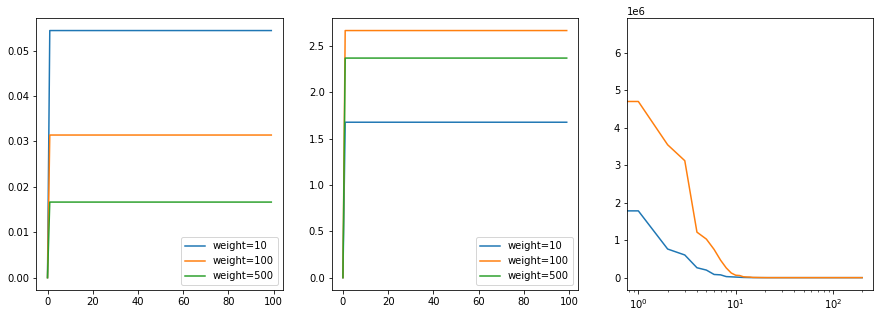

In [112]:
fig, ax = plt.subplots(1,3, figsize= (15,5))
for w in widths: 
    ax[0].plot(diffs[w], label=f"weight={w}")
    ax[1].plot(eig_diff[w], label=f"weight={w}")
ax[0].legend()
ax[1].legend()
ax[2].semilogx(eigenvals[0], label="weight=0")
ax[2].semilogx(eigenvals[9900], label="weo")
